In [1]:
from scipy.io import arff
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import keras.backend as K
from keras import regularizers
import keras_tuner as kt
from keras.utils.vis_utils import plot_model
from multi_label_metrics import *
from sklearn.calibration import calibration_curve
from BM import bm_counter
import tensorflow_probability as tfp
from sklearn.isotonic import IsotonicRegression
from stellargraph.calibration import TemperatureCalibration, IsotonicCalibration
from stellargraph.calibration import plot_reliability_diagram, expected_calibration_error
from calibration_module.calibrator import (
    HistogramCalibrator,
    PlattCalibrator,
    PlattHistogramCalibrator
)
from label_info import label_counter

In [2]:
from numpy.random import seed
seed(12)
from tensorflow.random import set_seed
set_seed(34)
data,_ = arff.loadarff(r'./dataset/yeast/yeast.arff')
df = pd.DataFrame(data) 
df=df.sample(frac=1,random_state = 1) #shuffle the data
rows,cols = df.shape
df.head()

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
535,0.155765,0.106403,-0.035367,-0.136857,-0.284304,-0.153110,-0.319761,-0.156661,-0.053910,0.181384,...,b'0',b'0',b'0',b'0',b'1',b'1',b'0',b'1',b'1',b'0'
936,0.067438,-0.086640,0.016308,-0.131930,0.092059,-0.155763,0.045003,-0.054296,0.046792,0.018881,...,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'1',b'1',b'0'
1815,-0.009172,0.005135,-0.068527,-0.059437,-0.193989,0.126675,-0.184806,0.117865,0.066552,0.096871,...,b'1',b'1',b'0',b'0',b'0',b'1',b'1',b'1',b'1',b'0'
297,-0.018043,-0.030532,0.006394,0.037218,0.048662,0.054159,-0.180368,0.141720,0.126975,-0.029195,...,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'1',b'1',b'0'
1065,0.520272,0.112940,0.018493,0.020344,-0.022716,-0.034295,-0.059520,-0.012996,-0.063361,-0.073279,...,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0'


In [3]:
split_index = int(rows * 0.8)
data_train:pd.DataFrame = df.iloc[:split_index,:]
data_test:pd.DataFrame = df.iloc[split_index:,:]
x_train = np.array(data_train.iloc[:,:-14].values,dtype ='float32')
y_train = np.array(data_train.iloc[:,-14:].values,dtype ='int')
x_test = np.array(data_test.iloc[:,:-14].values,dtype ='float32')
y_test = np.array(data_test.iloc[:,-14:].values,dtype ='int')

X = np.concatenate((x_train,x_test))
Y = np.concatenate((y_train,y_test))
label_info = label_counter(X,Y)

for l in range(len(label_info)):
    print("Number of instances with %s positive label(s): %s" %(l,label_info[l].astype("int32")))

Number of instances with 0 positive label(s): 0
Number of instances with 1 positive label(s): 32
Number of instances with 2 positive label(s): 412
Number of instances with 3 positive label(s): 112
Number of instances with 4 positive label(s): 1102
Number of instances with 5 positive label(s): 173
Number of instances with 6 positive label(s): 415
Number of instances with 7 positive label(s): 102
Number of instances with 8 positive label(s): 55
Number of instances with 9 positive label(s): 9
Number of instances with 10 positive label(s): 4
Number of instances with 11 positive label(s): 1
Number of instances with 12 positive label(s): 0
Number of instances with 13 positive label(s): 0
Number of instances with 14 positive label(s): 0


In [4]:
from keras.layers import Input,Dense
input_dim = cols-14
output_dim = 14
def build_model(hp):
    #hp = hyperparamters to be modified
    model = Sequential()
    model.add(Dense(hp.Int('units_1',min_value = 100,max_value = 160,step=20),input_dim=input_dim,activation='relu'))
    model.add(Dense(hp.Int('units_2',min_value = 60,max_value = 120,step=20),activation='relu'))
    model.add(Dense(hp.Int('units_3',min_value=40,max_value=70,step=10),activation='relu'))
    model.add(Dense(hp.Int('units_4',min_value=20,max_value=50,step=10),activation='relu'))
    model.add(Dense(hp.Int('units_5',min_value=20,max_value=50,step=10),activation='relu'))
    model.add(Dense(output_dim,activation='sigmoid'))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(learning_rate=learning_rate),metrics=['binary_accuracy',hamming_loss,precision_micro,recall_micro,f1_micro])
    return model

In [5]:
#Build Tuner 
tuner = kt.RandomSearch(
    build_model,
    kt.Objective("hamming_loss", direction="min"), #optimization objective is binary accuracy, for fault diagnosis can also be recall rate
    max_trials = 20,
    executions_per_trial = 2,
    overwrite = True,
    project_name="Scene_Tuner")

Trial 20 Complete [00h 00m 12s]
hamming_loss: 0.06660466082394123

Best hamming_loss So Far: 0.04557136446237564
Total elapsed time: 00h 04m 03s
INFO:tensorflow:Oracle triggered exit


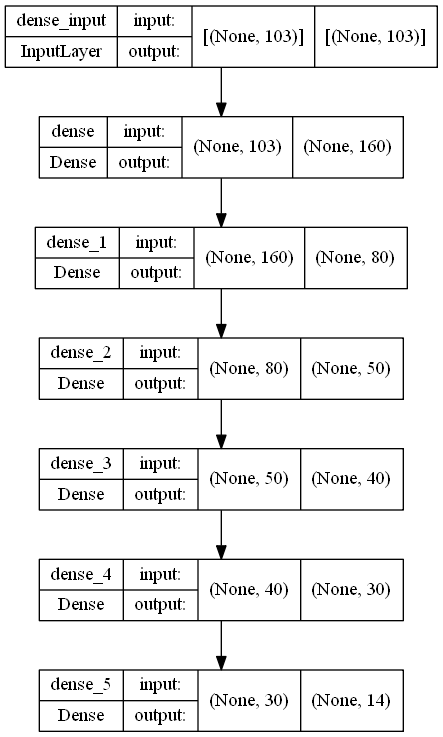

In [6]:
#get the best model with tuner
callback = tf.keras.callbacks.EarlyStopping(monitor='val_hamming_loss', patience=15)
tuner.search(x_train,y_train,epochs=60,batch_size=256,validation_split=0.33,shuffle=True,verbose=1)
best_model = tuner.get_best_models()[0]
plot_model(best_model, to_file='./best_model_yeast.png', show_shapes=True)

In [7]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               16640     
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 50)                4050      
                                                                 
 dense_3 (Dense)             (None, 40)                2040      
                                                                 
 dense_4 (Dense)             (None, 30)                1230      
                                                                 
 dense_5 (Dense)             (None, 14)                434       
                                                                 
Total params: 37,274
Trainable params: 37,274
Non-traina

In [8]:
#evaluate the best_model with test data
loss, accuracy,hamming_loss,precision_micro,recall_micro,f1_micro = best_model.evaluate(x_test, y_test)
print('Test:')
print('Loss: %s\nBinary-Accuracy(the same as Micro-Accuracy): %s \nHamming_Loss: %s \nMicro-Precision: %s \nMicro-Recall: %s \nMicro-F1 Score: %s' % (loss, accuracy,hamming_loss,precision_micro,recall_micro,f1_micro))

16/16 [==============================] - 1s 4ms/step - loss: 1.3245 - binary_accuracy: 0.7575 - hamming_loss: 0.2419 - precision_micro: 0.5942 - recall_micro: 0.5889 - f1_micro: 0.5898
Test:
Loss: 1.3244588375091553
Binary-Accuracy(the same as Micro-Accuracy): 0.7575266361236572 
Hamming_Loss: 0.2419084757566452 
Micro-Precision: 0.5941742658615112 
Micro-Recall: 0.5889022350311279 
Micro-F1 Score: 0.5898299813270569


In [9]:
y_pred = best_model.predict(x_test) 
predictions = (y_pred > 0.5).astype("int32")

In [10]:
recall_macro(y_test,predictions)

(array([0.5033557 , 0.54591837, 0.62433862, 0.63473054, 0.55102041,
        0.45528455, 0.24210526, 0.19387755, 0.05714286, 0.24528302,
        0.2295082 , 0.8       , 0.80054645, 0.        ]),
 0.4202222522365947)

In [11]:
precision_macro(y_test,predictions)


(array([0.56390977, 0.53233831, 0.59      , 0.56084656, 0.5472973 ,
        0.44094488, 0.42592593, 0.30645161, 0.14285714, 0.22807018,
        0.21538462, 0.80216802, 0.79619565, 0.        ]),
 0.43945642637793286)

In [12]:
f1_macro(y_test,predictions)

C:\Users\zhang\Desktop\Jupyter Notebook\multi_label_metrics.py:33: RuntimeWarning: invalid value encountered in true_divide
  f1_each_label = 2*((p*r)/(p+r))


(array([0.53191489, 0.53904282, 0.6066838 , 0.59550562, 0.54915254,
        0.448     , 0.30872483, 0.2375    , 0.08163265, 0.23636364,
        0.22222222, 0.80108254, 0.79836512,        nan]),
 nan)

In [13]:
accuracy_each_label(y_test,predictions)

array([0.72727273, 0.62190083, 0.6838843 , 0.70247934, 0.72520661,
       0.71487603, 0.78719008, 0.74793388, 0.90702479, 0.82644628,
       0.79752066, 0.69628099, 0.69421488, 0.9731405 ])

In [14]:
np.mean(accuracy_each_label(y_test,predictions))

0.7575265643447463

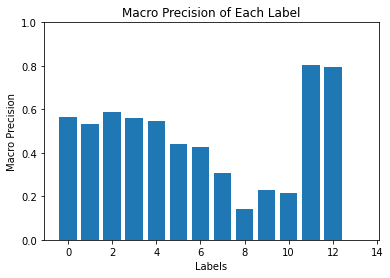

In [15]:
plt.bar(range(14),precision_macro(y_test,predictions)[0])
plt.ylim((0, 1))
plt.title('Macro Precision of Each Label')
plt.ylabel('Macro Precision')
plt.xlabel('Labels')
plt.savefig("./yeast_macro_precision.jpg" )

In [16]:
from sklearn.metrics import average_precision_score
average_precision_score(y_test, y_pred)

0.45122599026273963

In [17]:
#calibration 
data_val:pd.DataFrame = data_train.iloc[:int(split_index*1),:] #all the train data used for isotonic, logic described by Zadro, 
x_val = np.array(data_val.iloc[:,:-14].values,dtype ='float32')
y_val = np.array(data_val.iloc[:,-14:].values,dtype ='int')
y_val_pred = (best_model.predict(x_val))

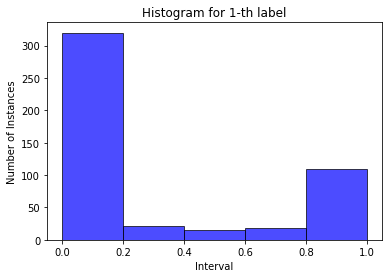

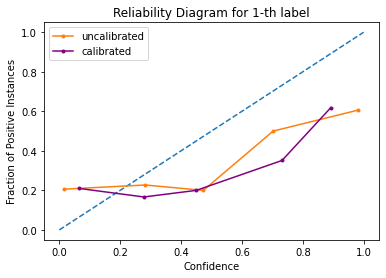

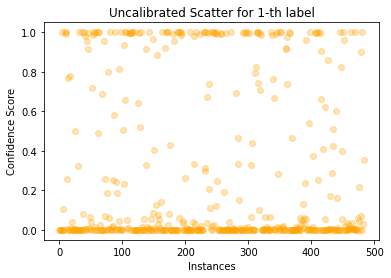

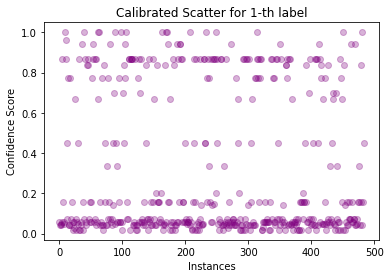

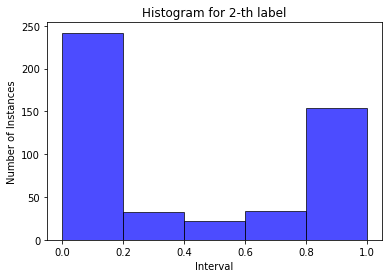

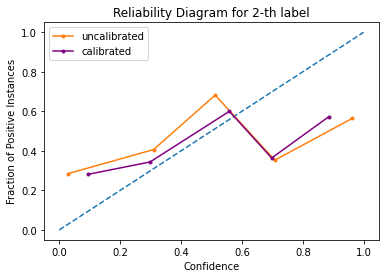

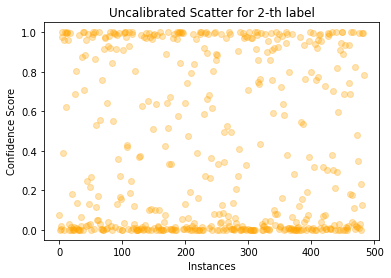

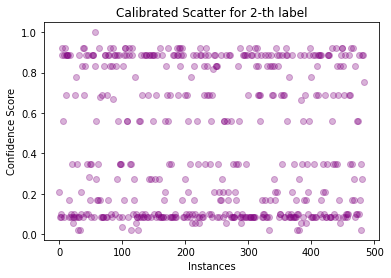

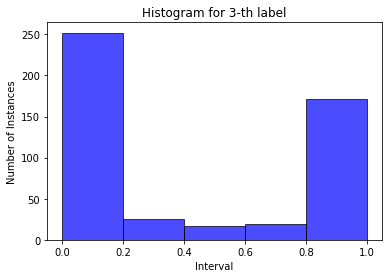

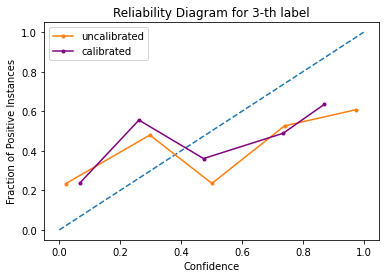

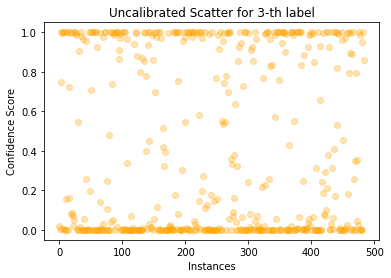

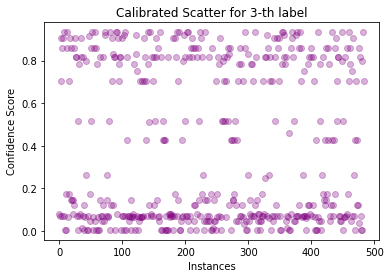

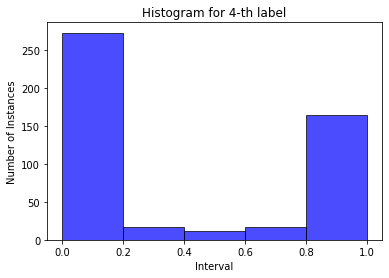

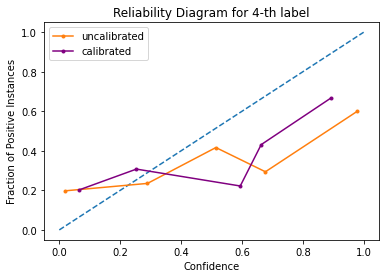

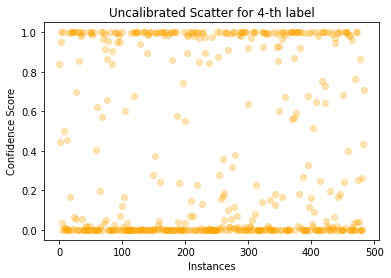

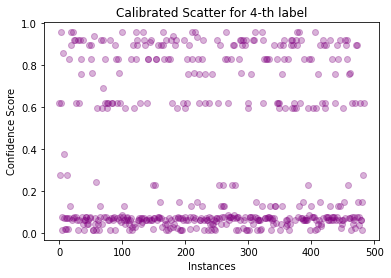

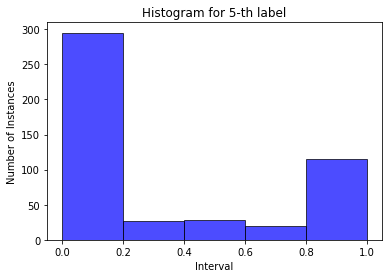

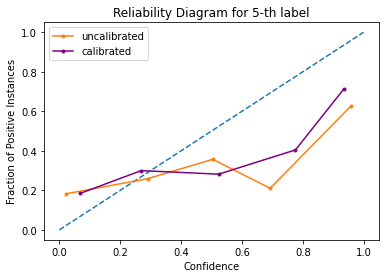

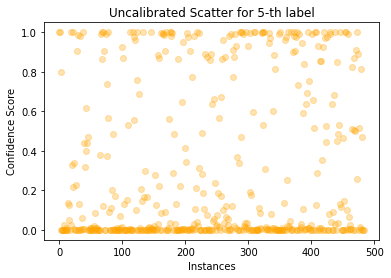

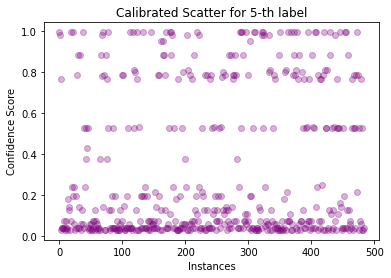

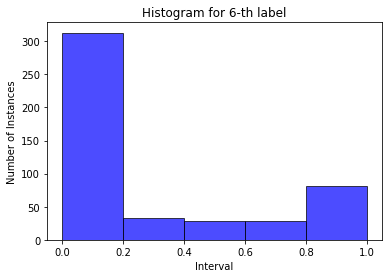

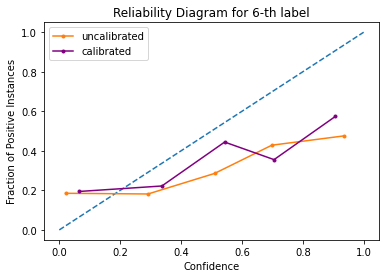

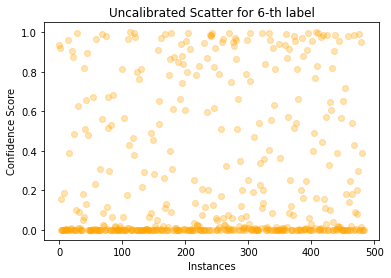

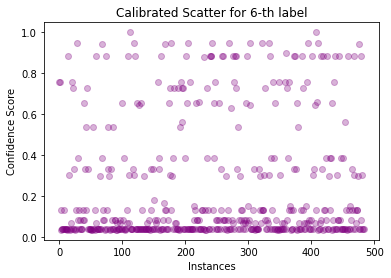

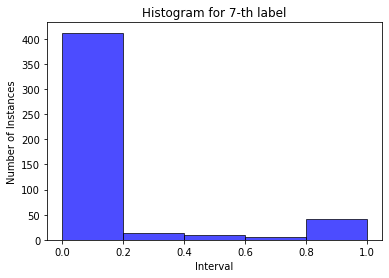

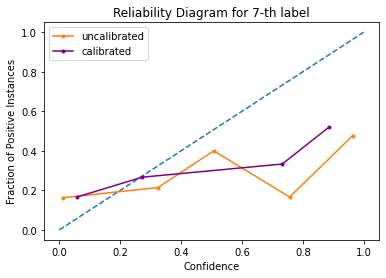

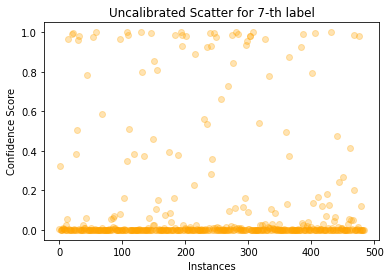

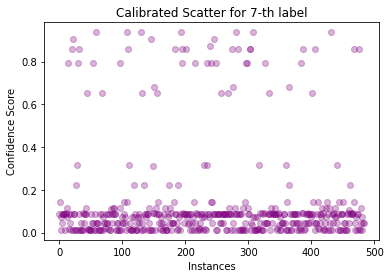

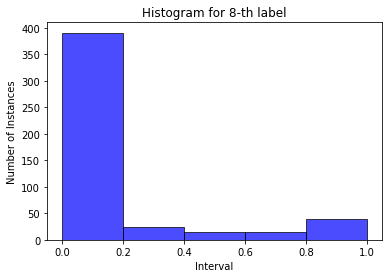

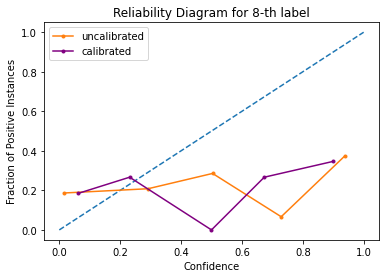

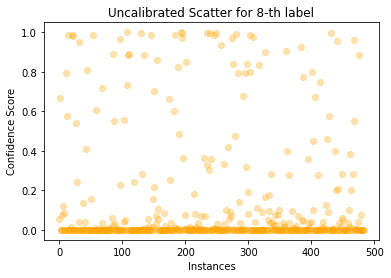

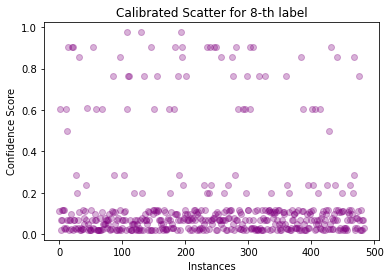

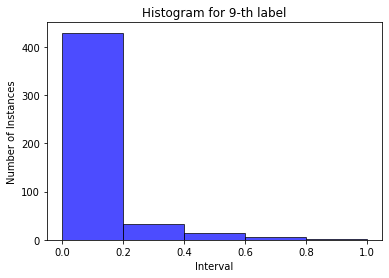

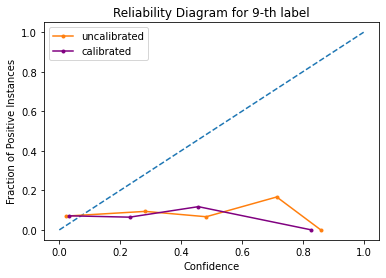

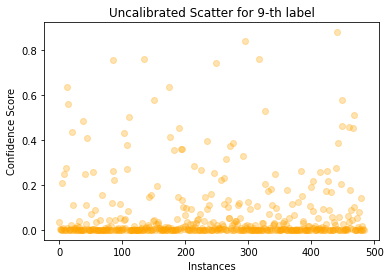

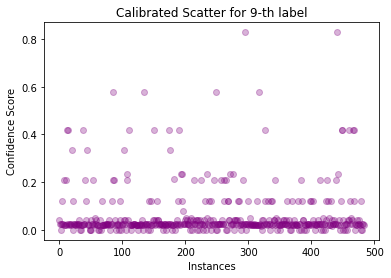

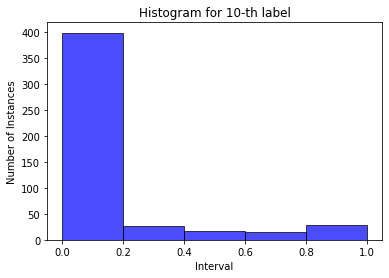

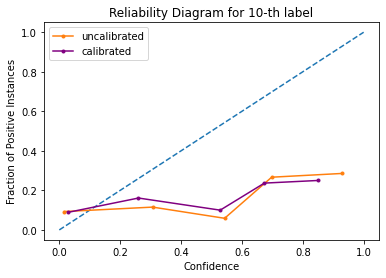

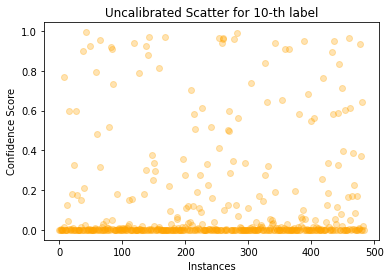

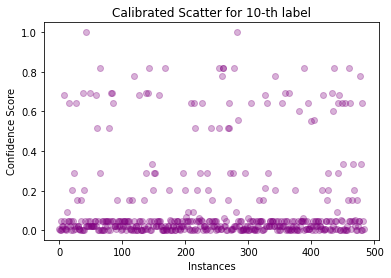

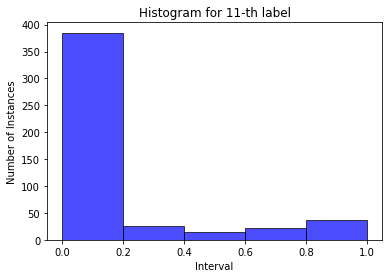

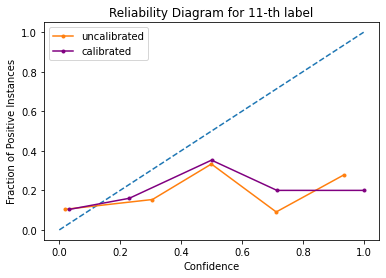

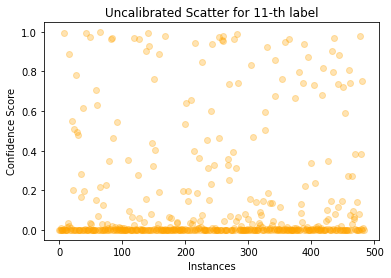

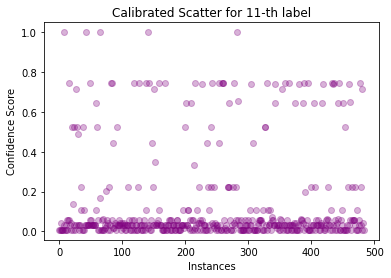

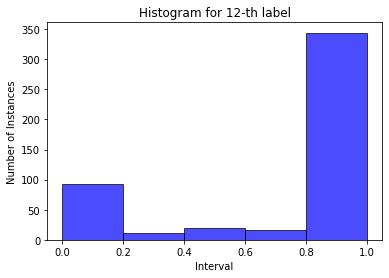

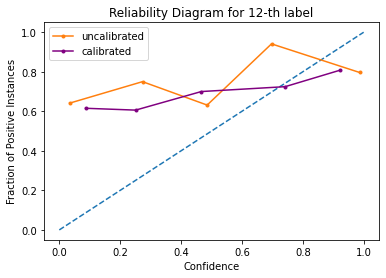

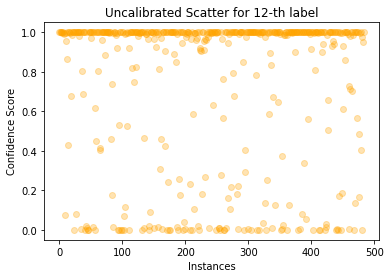

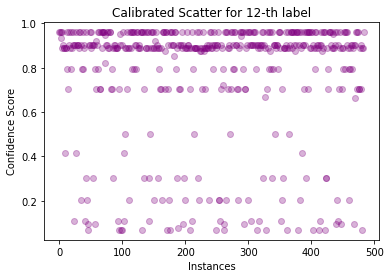

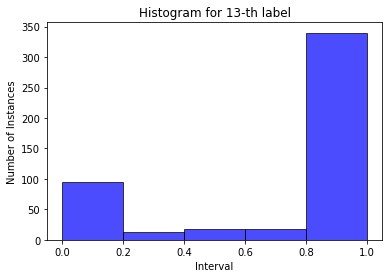

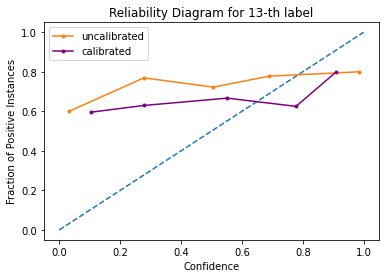

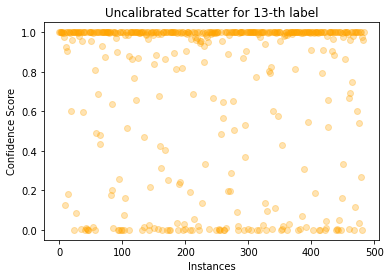

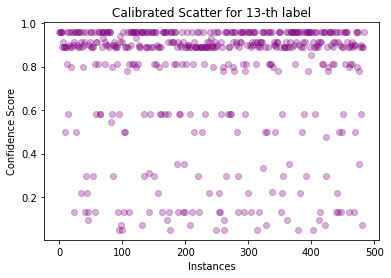

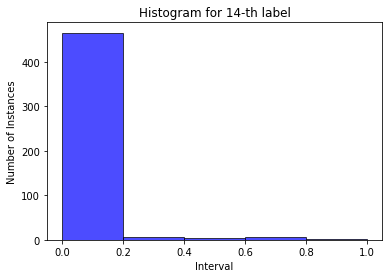

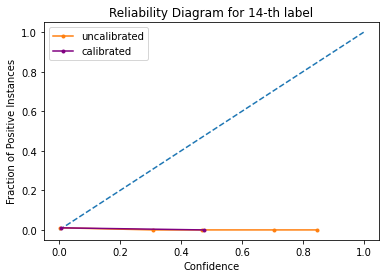

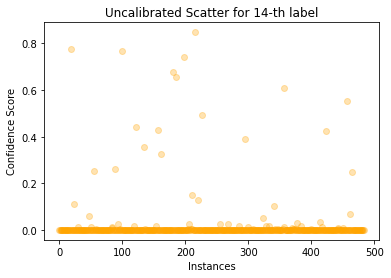

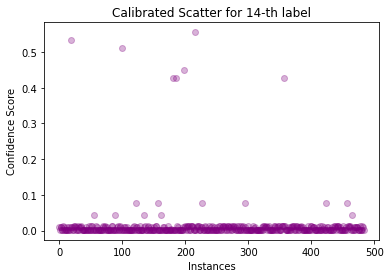

Expected Calibration Error for each label = [0.22966073587096672, 0.2937380143724553, 0.2676948459811434, 0.24749136095744653, 0.20517822161235577, 0.22045273556409667, 0.1844037048211576, 0.21670107965540347, 0.07825502153415319, 0.14050009719320655, 0.15896685985316236, 0.27666416377167824, 0.26626765155910354, 0.027148854647859863]
Expected Calibration Error for each label after Calibration = [0.19346994479487012, 0.2132551748659616, 0.1937811153903334, 0.17574910122962775, 0.16231466334867328, 0.16737682845689789, 0.13260951175446783, 0.15992577835024635, 0.06152246175487795, 0.11286502574620506, 0.12767494835482893, 0.15267929996648602, 0.16179361787031993, 0.010634560482182025]
Average Expected Calibration Error for all labels = 0.2009373819567278
Average Expected Calibration Error for all labels after Calibration = 0.14468943088328418


In [18]:
#Histograms of predictive value and reliability diagrams to show non-calibration 
ECE=[]
ECE_cal = []
calibrated_predictions =[]
bins =5
for i in range(np.shape(y_test)[1]):
    #val set for isotonic and train the isotonic model 
    ir = IsotonicRegression(out_of_bounds='clip',y_min=0,y_max=1)
    prob_val_true,prob_val_pred = calibration_curve(y_val[:,i],y_val_pred[:,i],n_bins=bins)
    ir.fit(y_val_pred[:,i],y_val[:,i])
    
    #histogram
    plt.hist(y_pred[:,i],bins = bins,range=(0,1),facecolor="blue", edgecolor="black", alpha=0.7)
    plt.title('Histogram for %s-th label' %(i+1))
    plt.ylabel('Number of Instances')
    plt.xlabel('Interval')
    plt.savefig("./yeast_hist_%s.jpg" %(i+1))
    plt.show()
    
    #reliability diagram
    prob_true, prob_pred = calibration_curve(y_test[:,i], y_pred[:,i], n_bins=bins) #acc for each bin, avg pred for each bin 
    Bm = bm_counter(y_pred[:,i],bins)
    Bm = Bm[Bm != 0]
    temp_ece=np.sum(abs(prob_pred - prob_true)*Bm)/np.shape(y_pred)[0]
    ECE.append(temp_ece)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(prob_pred, prob_true, marker='.',label = 'uncalibrated')
    
    #calibration with isotonic regression
    
    #iso for each label
    y_pred_cal = np.array(ir.predict(y_pred[:,i]),dtype="float32")
    calibrated_predictions.append((y_pred_cal>0.5).astype("int32"))
    prob_true_cal, prob_pred_cal = calibration_curve(y_test[:,i],y_pred_cal, n_bins = bins)
    Bm_cal = bm_counter(y_pred_cal,bins)
    Bm_cal = Bm_cal[Bm_cal!=0]
    temp_ece_cal=np.sum(abs(prob_pred_cal - prob_true_cal)*Bm_cal)/np.shape(y_pred_cal)[0]
    ECE_cal.append(temp_ece_cal)
    plt.plot(prob_pred_cal,prob_true_cal, marker='.',color = "purple", label='calibrated')
    plt.title('Reliability Diagram for %s-th label' %(i+1))
    plt.ylabel('Fraction of Positive Instances')
    plt.xlabel('Confidence')
    plt.legend()
    plt.savefig("./yeast_rd_%s.jpg" %(i+1),bbox_inches="tight")
    plt.show()
    
    #comparison of scatter before and after calibration
    plt.scatter(range(np.shape(y_pred)[0]),y_pred[:,i],color = "orange",label = ' uncalibrated',alpha= 0.3)
    plt.title('Uncalibrated Scatter for %s-th label' %(i+1))
    plt.ylabel('Confidence Score')
    plt.xlabel('Instances')
    plt.savefig("./yeast_scatter_uncal_%s.jpg" %(i+1),bbox_inches="tight")
    plt.show()
    
    plt.scatter(range(np.shape(y_pred_cal)[0]),y_pred_cal,color = "purple",label = 'calibrated',alpha = 0.3)
    plt.title('Calibrated Scatter for %s-th label' %(i+1))
    plt.ylabel('Confidence Score')
    plt.xlabel('Instances')
    plt.savefig("./yeast_scatter_cal_%s.jpg" %(i+1),bbox_inches="tight")
    plt.show()
calibrated_predictions = np.array(calibrated_predictions).T
print('Expected Calibration Error for each label = %s' %ECE)
print('Expected Calibration Error for each label after Calibration = %s' %ECE_cal)
avg_ECE = np.mean(ECE)
avg_ECE_cal= np.mean(ECE_cal)
print('Average Expected Calibration Error for all labels = %s' %avg_ECE)
print('Average Expected Calibration Error for all labels after Calibration = %s' %avg_ECE_cal)

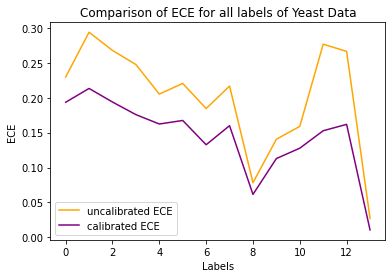

Uncalibrated Model macro metrics: 
 Recall: (array([0.5033557 , 0.54591837, 0.62433862, 0.63473054, 0.55102041,
       0.45528455, 0.24210526, 0.19387755, 0.05714286, 0.24528302,
       0.2295082 , 0.8       , 0.80054645, 0.        ]), 0.4202222522365947) 
 Precision: (array([0.56390977, 0.53233831, 0.59      , 0.56084656, 0.5472973 ,
       0.44094488, 0.42592593, 0.30645161, 0.14285714, 0.22807018,
       0.21538462, 0.80216802, 0.79619565, 0.        ]), 0.43945642637793286) 
 F1: (array([0.53191489, 0.53904282, 0.6066838 , 0.59550562, 0.54915254,
       0.448     , 0.30872483, 0.2375    , 0.08163265, 0.23636364,
       0.22222222, 0.80108254, 0.79836512,        nan]), nan) 
 Accuracy:[0.72727273 0.62190083 0.6838843  0.70247934 0.72520661 0.71487603
 0.78719008 0.74793388 0.90702479 0.82644628 0.79752066 0.69628099
 0.69421488 0.9731405 ] 

 ------------------------------------
Calibrated Model macro metrics:
 Recall: (array([0.52348993, 0.60204082, 0.62433862, 0.63473054, 0.5782312

C:\Users\zhang\Desktop\Jupyter Notebook\multi_label_metrics.py:33: RuntimeWarning: invalid value encountered in true_divide
  f1_each_label = 2*((p*r)/(p+r))


In [19]:
#calibrated model for test data evaluation Macro
plt.plot(range(14),ECE, label='uncalibrated ECE',color = "orange")
plt.plot(range(14),ECE_cal,color = "purple",label = 'calibrated ECE')
plt.title('Comparison of ECE for all labels of Yeast Data')
plt.ylabel('ECE')
plt.xlabel('Labels')
plt.legend()
plt.savefig("./yeast_ece_comparison.jpg" )
plt.show()
print("Uncalibrated Model macro metrics: \n Recall: %s \n Precision: %s \n F1: %s \n Accuracy:%s \n" 
      %(recall_macro(y_test,predictions),precision_macro(y_test,predictions),
      f1_macro(y_test,predictions),accuracy_each_label(y_test,predictions))+"\n ------------------------------------")
print("Calibrated Model macro metrics:\n Recall: %s \n Precision: %s \n F1: %s \n Accuracy:%s \n"
      %(recall_macro(y_test,calibrated_predictions),precision_macro(y_test,calibrated_predictions),
      f1_macro(y_test,calibrated_predictions),accuracy_each_label(y_test,calibrated_predictions)))

In [30]:
c=0
for i in range(np.shape(y_train)[0]):
    if y_train[i][8] == 1:
        c+=1
c/i

0.07401656314699794